# Desafio EDA

Ao longo deste notebook faremos uma análise descritiva dos dados documentando e ilustrando cada passo dado, assim como, as informações extraídas, tentando gerar insights para possíveis abordagens do dataset.

Importação das bibliotecas usadas:
* pandas e numpy -> leitura e manipulação dos dados
* seaborn e matplotlib -> visualização dos dados e informações extraídas
* math -> operações matemáticas
* gensin -> importação e execução de word embedding para modelo de similaridade

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import log
from gensim.models import KeyedVectors
import gensim.downloader

In [2]:
sns.set(color_codes=True)

Leitura do dataset:

In [3]:
receitas = pd.read_json("data/receitas.json")
receitas.head()

,calories,categories,date,desc,directions,fat,ingredients,protein,rating,sodium,title
0,426.0,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",2006-09-01 04:00:00,None,"[1. Place the stock, lentils, celery, carrot, ...",7.0,"[4 cups low-sodium vegetable or chicken stock,...",30.0,2.500,559.0,"Lentil, Apple, and Turkey Wrap"
1,403.0,"[Food Processor, Onion, Pork, Bake, Bastille D...",2004-08-20 04:00:00,This uses the same ingredients found in boudin...,[Combine first 9 ingredients in heavy medium s...,23.0,"[1 1/2 cups whipping cream, 2 medium onions, c...",18.0,4.375,1439.0,Boudin Blanc Terrine with Red Onion Confit
2,165.0,"[Soup/Stew, Dairy, Potato, Vegetable, Fennel, ...",2004-08-20 04:00:00,None,[In a large heavy saucepan cook diced fennel a...,7.0,"[1 fennel bulb (sometimes called anise), stalk...",6.0,3.750,165.0,Potato and Fennel Soup Hodge
3,NaN,"[Fish, Olive, Tomato, Sauté, Low Fat, Low Cal,...",2009-03-27 04:00:00,The Sicilian-style tomato sauce has tons of Me...,[Heat oil in heavy large skillet over medium-h...,NaN,"[2 tablespoons extra-virgin olive oil, 1 cup c...",NaN,5.000,NaN,Mahi-Mahi in Tomato Olive Sauce
4,547.0,"[Cheese, Dairy, Pasta, Vegetable, Side, Bake, ...",2004-08-20 04:00:00,None,[Preheat oven to 350°F. Lightly grease 8x8x2-i...,32.0,"[1 12-ounce package frozen spinach soufflé, th...",20.0,3.125,452.0,Spinach Noodle Casserole


Descobrindo as dimensões do dataset (Nº de Instâncias x Nº de Atributos):

In [4]:
receitas.shape

(20130, 11)

Explorando valores dos atributos numéricos:

In [5]:
receitas.describe()

,calories,fat,protein,rating,sodium
count,1.597600e+04,1.590800e+04,15929.000000,20100.000000,1.597400e+04
mean,6.307857e+03,3.460975e+02,99.946199,3.713060,6.211474e+03
std,3.585851e+05,2.043102e+04,3835.616663,1.343144,3.328903e+05
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00
25%,1.980000e+02,7.000000e+00,3.000000,3.750000,8.000000e+01
50%,3.310000e+02,1.700000e+01,8.000000,4.375000,2.940000e+02
75%,5.860000e+02,3.300000e+01,27.000000,4.375000,7.110000e+02
max,3.011122e+07,1.722763e+06,236489.000000,5.000000,2.767511e+07


Já podemos observar pela linha __count__ que existem uma boa quantidade de itens nulos nestas colunas do dataset, além dos valores médios, mínimos e máximos das colunas que já nos indicam uma muito possível presença de outliers, considerando o domínio do dataset (uma receita com 27 milhões em sódio quando os valores do terceiro quertil é 711?). Ambas as situações detectadas serão abordadas logo mais.

Verificando o número de ocorrências de **missing values** em cada uma das colunas do dataset:

In [6]:
counts = {col: [receitas[col].isnull().sum()] for col in receitas}
print(counts)
missing_values = pd.DataFrame.from_dict(counts, orient='index', columns=['Missing Values'])
missing_values

{'calories': [4154], 'categories': [19], 'date': [19], 'desc': [6635], 'directions': [19], 'fat': [4222], 'ingredients': [19], 'protein': [4201], 'rating': [30], 'sodium': [4156], 'title': [19]}


,Missing Values
calories,4154
categories,19
date,19
desc,6635
directions,19
fat,4222
ingredients,19
protein,4201
rating,30
sodium,4156


Uma solução comumente usada aqui seria filtrar e retirar, todas as linhas com valores nulos da dataset, mas como ainda estamos explorando e não sabemos exatamente quais atributos podem ser mais ou menos relevantes, vamos por ora, eliminar apenas as instâncias sem um nome (title) e sem uma avaliação, por serem uma quantidade quase irrisória de ocorrências. 

Uma abordagem alternativa seria a imputação de dados, mas precisaríamos de garantia de que os valores dos atributos não possuem outliers e de que eles sejam discretos, o que não temos ainda.

In [7]:
receitas = receitas.dropna(subset=['title', 'rating'])

In [8]:
counts = {col: [receitas[col].isnull().sum()] for col in receitas}
#print(counts)
missing_values = pd.DataFrame.from_dict(counts, orient='index', columns=['Missing Values'])
missing_values

,Missing Values
calories,4131
categories,0
date,0
desc,6616
directions,0
fat,4199
ingredients,0
protein,4178
rating,0
sodium,4133


Notamos que as ocorrências de missing value tinha recorrência dentro de cada instãncia, já que ao simplesmente realizarmos o drop para as duas categorias citadas, zeramos as ocorrências de dados faltantes em outras 3 colunas.

Checagem das colunas quanto a tipo:

In [9]:
receitas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20100 entries, 0 to 20129
Data columns (total 11 columns):
calories       15969 non-null float64
categories     20100 non-null object
date           20100 non-null datetime64[ns]
desc           13484 non-null object
directions     20100 non-null object
fat            15901 non-null float64
ingredients    20100 non-null object
protein        15922 non-null float64
rating         20100 non-null float64
sodium         15967 non-null float64
title          20100 non-null object
dtypes: datetime64[ns](1), float64(5), object(5)
memory usage: 1.8+ MB


Afim de continuarmos a limpeza dos dados, vamos usar um pequeno artifício para através de pandas compararmos valores de listas e sermos capazes de remover dados duplicados, vamos considerar uma receita duplicada, se já existir alguma outra com os mesmos com título, ingredientes e direção idêntica.

In [10]:
f = lambda x : "#!#".join([str(i) for i in x])

In [11]:
#receitas['categories'] = receitas['categories'].apply(f)
receitas['directions'] = receitas['directions'].apply(f)
receitas['ingredients'] = receitas['ingredients'].apply(f)

Resultado da remoção de duplicadas:

In [12]:
receitas = receitas.drop_duplicates(subset=['title', 'directions', 'ingredients'])
receitas.shape

(18245, 11)

Descobrindo limites do atributo "date":

In [13]:
min(receitas['date'].unique())

numpy.datetime64('1996-09-01T20:47:00.000000000')

In [14]:
max(receitas['date'].unique())

numpy.datetime64('2016-12-13T13:00:00.000000000')

Notamos acima que temos instâncias que datam do ano de 1996 até 2016, vamos ver mais abaixo como se dará a distribuição de receitas ao longo dos anos:

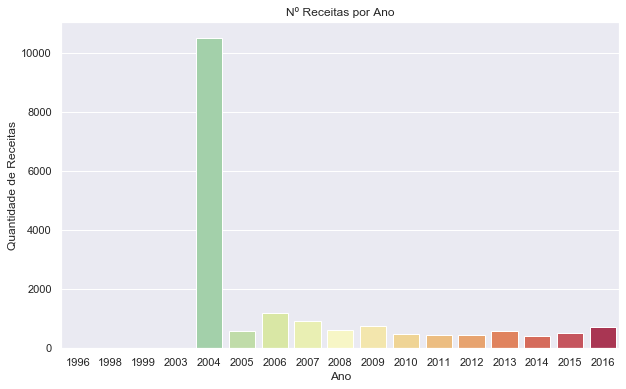

In [15]:
years = sorted(receitas['date'].dt.year.unique())
conts = [list(receitas['date'].dt.year).count(i) for i in years]

plt.figure(figsize=(10, 6))
plt.title('Nº Receitas por Ano')
plt.xlabel('Ano')
plt.ylabel('Quantidade de Receitas')
#plt.xticks(rotation=85)
#sns.barplot(x=countries, y=occ, order=sorted(occ, reverse=True));
sns.barplot(x=years, y=conts, palette="Spectral_r");

Percebe-se que houve um grande pico de receitas no ano de 2004, represetando mais da metade das instâncias do dataset, antes disso porém, o número de ocorrências é praticamente inexpressivo a ponto de nem ser plotado no gráfico, por isso vamos optar por estudar o intervalo 2004-2016. Destaca-se que pela enorme expressividade de dados presentes no ano de 2004 ele poderia ser estudado inclsive de forma isolada.

In [16]:
receitas['year'] = receitas['date'].dt.year

In [17]:
receitas = receitas[receitas['year'] > 2003]

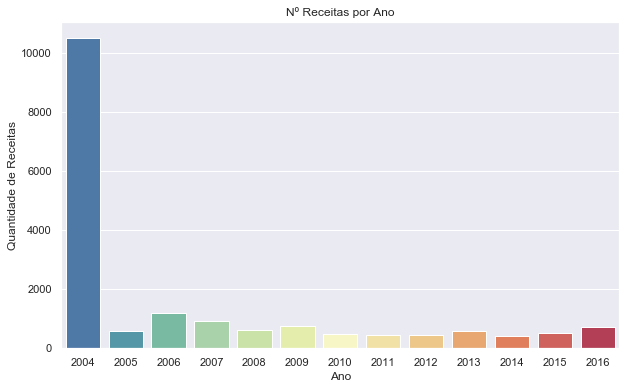

In [18]:
years = sorted(receitas['date'].dt.year.unique())
conts = [list(receitas['date'].dt.year).count(i) for i in years]

plt.figure(figsize=(10, 6))
plt.title('Nº Receitas por Ano')
plt.xlabel('Ano')
plt.ylabel('Quantidade de Receitas')
#plt.xticks(rotation=85)
#sns.barplot(x=countries, y=occ, order=sorted(occ, reverse=True));
sns.barplot(x=years, y=conts, palette="Spectral_r");

Devido a grande predominância dos dados no ano de 2004, pode-se ter dificuldade de as informações dos anos subsequentes ou alguma tendência em relação a eles, desta forma vamos plotar os mesmos dados mas parametrizando as ocorrências com a função log.

[2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004]


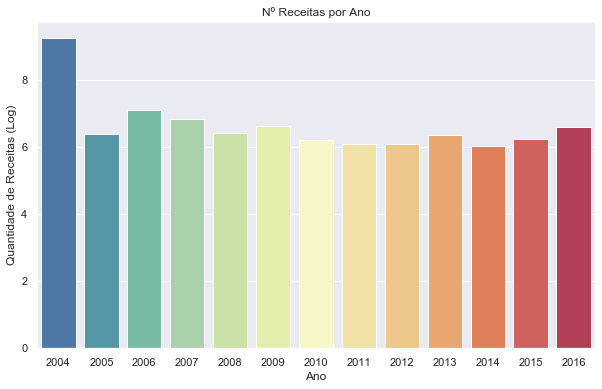

In [19]:
years = sorted(receitas['date'].dt.year.unique(), reverse=True)
print(years)
conts = [list(receitas['date'].dt.year).count(i) for i in years]
contl = list(map(log, conts))
plt.figure(figsize=(10, 6))
plt.title('Nº Receitas por Ano')
plt.xlabel('Ano')
plt.ylabel('Quantidade de Receitas (Log)')
#plt.xticks(rotation=85)
#sns.barplot(x=countries, y=occ, order=sorted(occ, reverse=True));
sns.barplot(x=years, y=contl, palette="Spectral_r");

Apesar de pequena podemos perceber que existem algumas tendências visíveis no dataset, como uma leve queda entre os anos de 2009 até 2012, e uma alta entre os anos 2014 e 2016.

Seguinda a abordagem temporal, vamos ver como se comporta a média de calorias das receitas ao longo dos anos:

[638.5515267175573, 583.6853658536585, 450.1993006993007, 515.8280802292263, 460.67192429022083, 454.17241379310343, 470.1338912133891, 517.2912621359224, 10912.743181818181, 6459.577968526466, 61543.45583756345, 488.1094339622642, 2722.3140745717164]


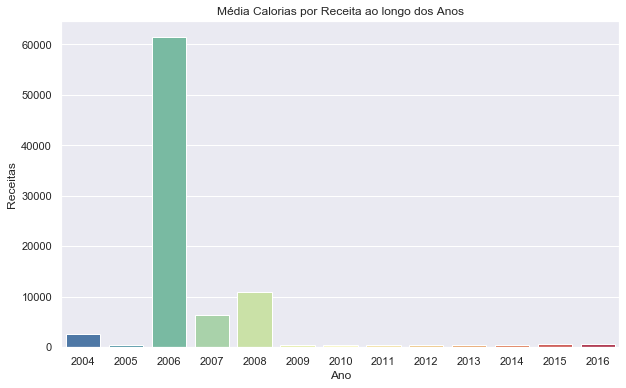

In [20]:
cal = []
for y in years:
    aux = list(receitas[receitas['date'].dt.year == y]['calories'].dropna())
    cal_m = sum(aux)/len(aux)
    cal.append(cal_m)
print(cal)
plt.figure(figsize=(10, 6))
plt.title('Média Calorias por Receita ao longo dos Anos')
plt.xlabel('Ano')
plt.ylabel('Receitas')
#plt.xticks(rotation=85)
#sns.barplot(x=countries, y=occ, order=sorted(occ, reverse=True));
#sns.barplot(x='year', y='calories', data=receitas.dropna(subset=['calories']), palette="Spectral");
sns.barplot(x=years, y=cal, palette="Spectral_r");

Nota-se claramente uma disparidade especialmente no ano de 2006 em relação aos outros anos, indicando possivelmente a presença de outliers, por isso vamos investigar mais a fundo

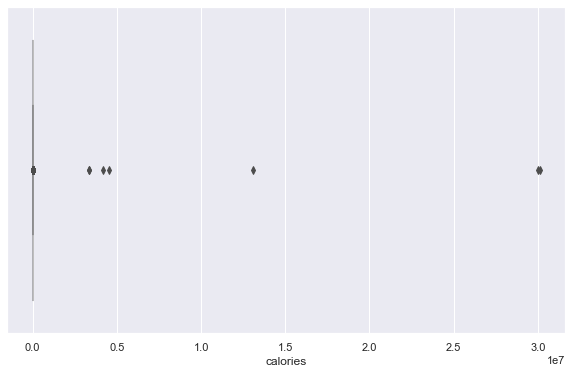

In [21]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='calories', data=receitas, orient='h', linewidth=0.4);

O boxplot acima analisando os valores totais da coluna calorias, indica que realmente existem outliers, abaixo podemos ver que apesar de não estarem exclusivamente no ano de 2006 é onde se encontra o mais distoante, fazendo inclusive todo o gráfico parecer destorcido.

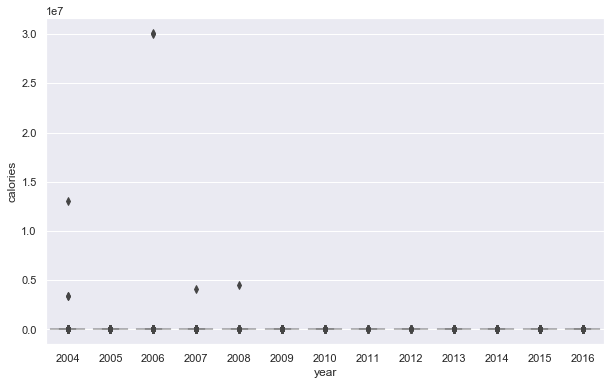

In [22]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='year', y='calories', data=receitas, linewidth=0.4);

Calculos dos limites aceitos dentro do dataset, para fazermos um corte:

In [23]:
qua = list(receitas['calories'].quantile([0.25, 0.5, 0.75]))
qua

[205.0, 346.0, 600.0]

In [24]:
fiq = qua[2]-qua[0]
fiq

395.0

In [25]:
low_limit = qua[0] - 1.5*fiq
low_limit

-387.5

In [26]:
high_limit = qua[2] + 1.5*fiq
high_limit

1192.5

In [27]:
sum(i < low_limit for i in receitas['calories'])

0

Número de isntâncias que serão descartadas com a aplicação da operação:

In [28]:
sum(i > high_limit for i in receitas['calories'])

905

In [29]:
receitas = receitas[receitas['calories'] < high_limit]

Gráficos boxplot após a operação de corte:

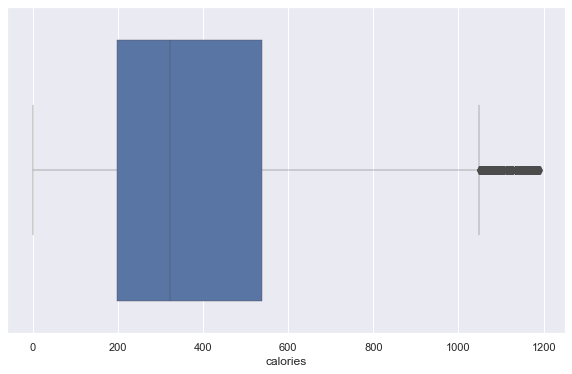

In [30]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='calories', data=receitas, orient='h', linewidth=0.4);

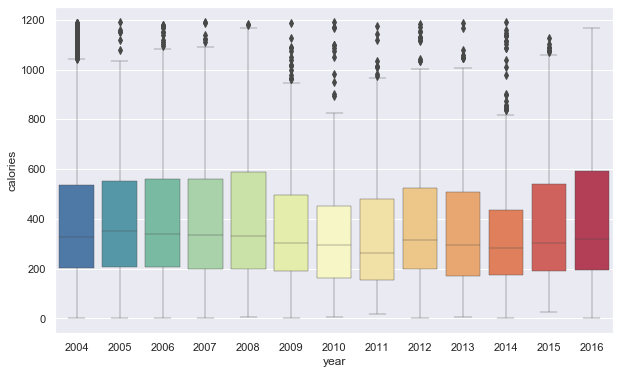

In [31]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='year', y='calories', data=receitas, linewidth=0.4, palette="Spectral_r");

Gráfico de calorias médias ao longo dos anos após a remoção dos outilers:

[408.5609243697479, 383.93150684931504, 352.1217712177122, 354.4704049844237, 393.9801324503311, 357.5327868852459, 350.5156950672646, 366.3690721649485, 411.77777777777777, 397.51384615384615, 400.2872807017544, 402.69939879759517, 392.6406936690818]


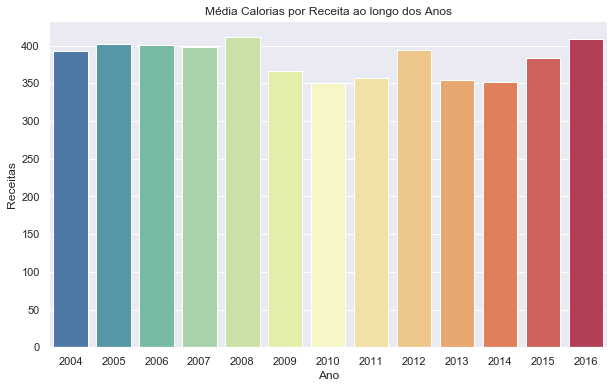

In [32]:
cal = []
for y in years:
    aux = list(receitas[receitas['date'].dt.year == y]['calories'].dropna())
    cal_m = sum(aux)/len(aux)
    cal.append(cal_m)
print(cal)
plt.figure(figsize=(10, 6))
plt.title('Média Calorias por Receita ao longo dos Anos')
plt.xlabel('Ano')
plt.ylabel('Receitas')
#plt.xticks(rotation=85)
#sns.barplot(x=countries, y=occ, order=sorted(occ, reverse=True));
#sns.barplot(x='year', y='calories', data=receitas.dropna(subset=['calories']), palette="Spectral");
sns.barplot(x=years, y=cal, palette="Spectral_r");

Novamente pequena, mas nota-se uma tendência crescente de receitas mais calóricas nos anos mais recentes do dataset (2014-2016)

Dimensões do dataset após a remoção de parte dos outliers

In [33]:
receitas.shape

(13581, 12)

In [34]:
counts = {col: [receitas[col].isnull().sum()] for col in receitas}
#print(counts)
missing_values = pd.DataFrame.from_dict(counts, orient='index', columns=['Missing Values'])
missing_values

,Missing Values
calories,0
categories,0
date,0
desc,4624
directions,0
fat,53
ingredients,0
protein,33
rating,0
sodium,1


Temos acima a tabela de missing values para cada atributo, deixando claro que a remoção dos outliers gerou um impacto também na diminuição de dados faltantes

Vamos aproveitar a remoção dos outliers para explorar o atributo categorias de cada receita

In [35]:
cat = {}
receitas_cat = list(receitas['categories'])

for rec in receitas_cat:
    for c in rec:
        if c not in cat:
            cat[c] = 1
        else:
            cat[c] += 1

Top 20 Categorias mais populares e número de ocorrências dentro do dataset:

In [36]:
tags_occ = pd.DataFrame.from_dict(cat, orient='index', columns=['Ocorrências'])
tags_occ = tags_occ.sort_values(by=['Ocorrências'], ascending=False)
tags_occ.head(20)

,Ocorrências
Bon Appétit,6400
Peanut Free,5805
Soy Free,5615
Vegetarian,4845
Tree Nut Free,4813
Gourmet,4813
Kosher,4340
Pescatarian,4293
Quick & Easy,3675
Wheat/Gluten-Free,3372


Gráfico de categorias mais populares em proporção, o primeiro no ranking, "Bon Appétit", aparece quase 5 vezes mais que o vigésimo, "Sugar Conscious".

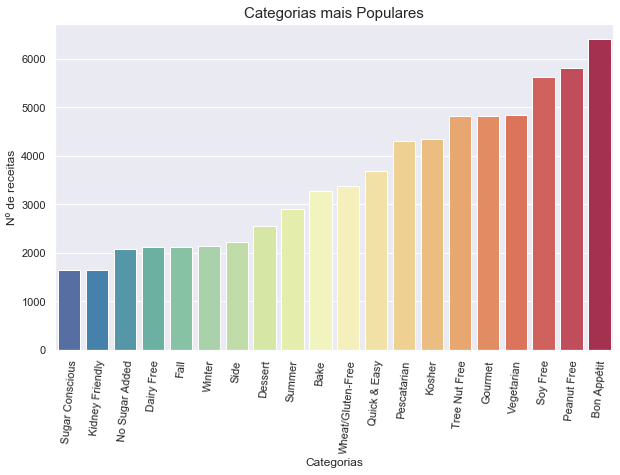

In [37]:
aux = [(i[0], i[1]) for i in list(zip(tags_occ.head(20)['Ocorrências'], tags_occ.head(20).index))]
aux = sorted(aux, key=lambda k: k[0])
#print(aux)
plt.figure(figsize=(10, 6))
plt.title('Categorias mais Populares', fontsize=15)
plt.ylabel('Nº de receitas')
plt.xlabel('Categorias')
plt.xticks(rotation=85)
#sns.barplot(x=countries, y=occ, order=sorted(occ, reverse=True));
#sns.barplot(x='year', y='calories', data=receitas.dropna(subset=['calories']), palette="Spectral");
sns.barplot(x=[i[1] for i in aux], y=[i[0] for i in aux], palette="Spectral_r");

In [38]:
x = sorted(years, reverse=False)
y = {col : [] for col in tags_occ[:15].index}
print(y)
for year in x:
    aux = receitas[receitas['year'] == year]
    tag = aux['categories']
    for col in y:
        cont = 0
        for c in list(tag):
            if col in c:
                cont += 1
        y[col].append(cont)
#y

{'Bon Appétit': [], 'Peanut Free': [], 'Soy Free': [], 'Vegetarian': [], 'Tree Nut Free': [], 'Gourmet': [], 'Kosher': [], 'Pescatarian': [], 'Quick & Easy': [], 'Wheat/Gluten-Free': [], 'Bake': [], 'Summer': [], 'Dessert': [], 'Side': [], 'Winter': []}


In [39]:
f = lambda a: [sum(a[:i]) for i in range(1, len(a)+1)]

Explorando o crescimento das Top 15 categorias de receitas, ao longo do anos, no intervalo 2004-2016, algumas categorias como "Gourmet" e "Quick & Easy" aparentam um crescimento mais estancado, enquanto "Wheat/Gluten-Free", "Vegetarian" e algumas outras, mostram um crescimento considerável, inclusive ultrapassando outras categorias antes mais populares.

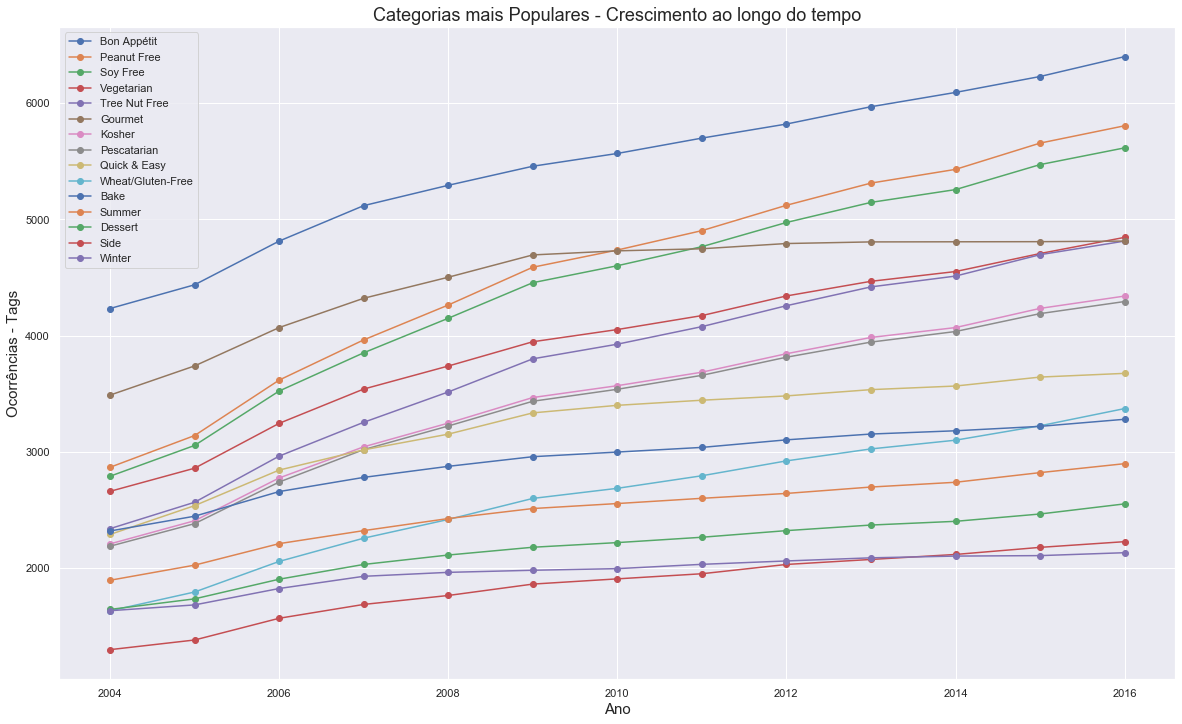

In [40]:
#y = list(results_norm['Silhouette'])
plt.figure(figsize=(20,12))
plt.xlabel('Ano', fontsize=15)
plt.ylabel('Ocorrências - Tags', fontsize=15)
plt.title("Categorias mais Populares - Crescimento ao longo do tempo", fontsize=18)
for col in y:
    soma = f(y[col])
    plt.plot(x,soma,marker='o', label=col);
    plt.legend()

Para avaliar as categorias que mais cresceram neste intervalo de tempo, vamos coletar os dados referentes aos dois limites  2004 e 2016, com a intenção de analisarmos quais categorias cresceram mais nesse tempo, dando em números brutos quanto em proporção.

In [41]:
ym = min(x)
ym

2004

In [42]:
cat_2004 = {}
for c in cat:
    cat_2004[c] = 0
    aux = receitas[receitas['year'] == ym]
    occ = sum([c in i for i in list(aux['categories'])])
    cat_2004[c] = occ

In [43]:
cat_2004['Bon Appétit']

4233

Categorias mais populares 2004:

In [44]:
tags_occ_2004 = pd.DataFrame.from_dict(cat_2004, orient='index', columns=['Ocorrências 2004'])
tags_occ_2004 = tags_occ_2004.sort_values(by=['Ocorrências 2004'], ascending=False)
tags_occ_2004.head(20)

,Ocorrências 2004
Bon Appétit,4233
Gourmet,3488
Peanut Free,2867
Soy Free,2790
Vegetarian,2660
Tree Nut Free,2339
Bake,2319
Quick & Easy,2289
Kosher,2208
Pescatarian,2188


Unindo os dataframes:

In [45]:
tags_occ = tags_occ.join(tags_occ_2004)
tags_occ.head()

,Ocorrências,Ocorrências 2004
Bon Appétit,6400,4233
Peanut Free,5805,2867
Soy Free,5615,2790
Vegetarian,4845,2660
Tree Nut Free,4813,2339


Cáculo do crescimento em números brutos (o dataset está ordenado pelo crescimento, então também é uma tabela das categorias que mais cresceram em dados brutos):

In [46]:
tags_occ['growth_raw'] = tags_occ['Ocorrências']-tags_occ['Ocorrências 2004']
#tags_occ = tags_occ.sort_values(by=['dif'], ascending=False)
tags_occ.sort_values(by=['growth_raw'], ascending=False)[:10]

,Ocorrências,Ocorrências 2004,growth_raw
Peanut Free,5805,2867,2938
Soy Free,5615,2790,2825
Tree Nut Free,4813,2339,2474
Vegetarian,4845,2660,2185
Bon Appétit,6400,4233,2167
Kosher,4340,2208,2132
Pescatarian,4293,2188,2105
Wheat/Gluten-Free,3372,1632,1740
Quick & Easy,3675,2289,1386
Gourmet,4813,3488,1325


Cáculo de crescimento proporcional e principais categorias nessa questão

In [47]:
percent = []
for i in list(zip(list(tags_occ['Ocorrências']), list(tags_occ['Ocorrências 2004']))):
    if i[1] == 0:
        percent.append(0)
    else:
        percent.append((i[0]/i[1])*100)
tags_occ['growth_percent'] = percent
#tags_occ = tags_occ.sort_values(by=['dif'], ascending=False)
tags_occ[tags_occ['Ocorrências 2004'] > 50].sort_values(by=['growth_percent'], ascending=False)[:10]

,Ocorrências,Ocorrências 2004,growth_raw,growth_percent
Low Fat,289,66,223,437.878788
Dinner,1547,361,1186,428.531856
Potluck,323,82,241,393.902439
High Fiber,544,159,385,342.138365
Low Cal,505,162,343,311.728395
Seafood,249,86,163,289.534884
Backyard BBQ,576,209,367,275.598086
Kid-Friendly,1170,445,725,262.921348
Fourth of July,239,91,148,262.637363
Christmas Eve,195,76,119,256.578947


In [48]:
x = sorted(years, reverse=False)
y = {col : [] for col in tags_occ.sort_values(by=['growth_raw'], ascending=False)[:10].index}
#print(y)
for year in x:
    aux = receitas[receitas['year'] == year]
    tag = aux['categories']
    for col in y:
        cont = 0
        for c in list(tag):
            if col in c:
                cont += 1
        y[col].append(cont)

Categorias que mais cesceram em dados brutos ao longo dos anos:

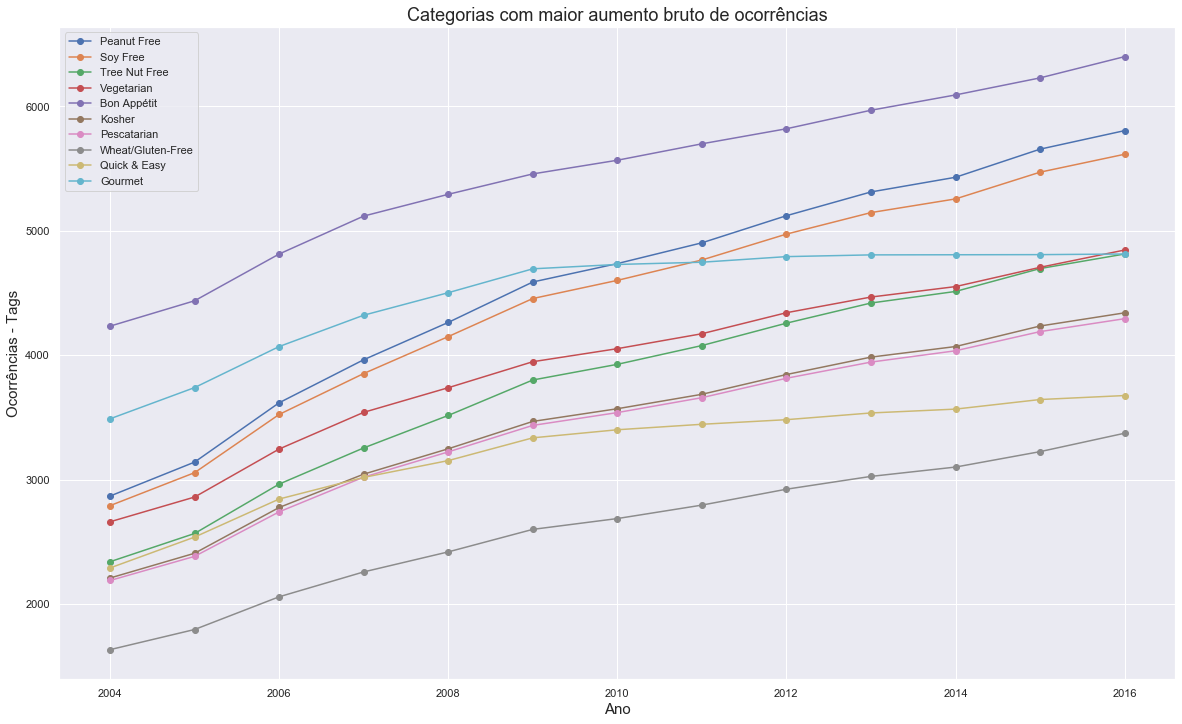

In [49]:
plt.figure(figsize=(20,12))
plt.xlabel('Ano', fontsize=15)
plt.ylabel('Ocorrências - Tags', fontsize=15)
plt.title("Categorias com maior aumento bruto de ocorrências", fontsize=18)
for col in y:
    soma = f(y[col])
    plt.plot(x,soma,marker='o', label=col);
    plt.legend()

No gráfico acima não vemos muita diferença entre estas categorias e as presentes nas categorias mais populares no geral, mas destaca-se novamente a crescente de "Soy Free", "Vegetarian", "Tree Nut Free" e a estabilização de "Gourmet" por exemplo.

In [50]:
x = sorted(years, reverse=False)
y = {col : [] for col in tags_occ[tags_occ['Ocorrências 2004'] > 50].sort_values(by=['growth_percent'], ascending=False)[:10].index}
#print(y)
for year in x:
    aux = receitas[receitas['year'] == year]
    tag = aux['categories']
    for col in y:
        cont = 0
        for c in list(tag):
            if col in c:
                cont += 1
        y[col].append(cont)

Categorias com maior crescimento proprocional entre 2004 e 2016, destaque para 'Dinner' e 'Kid-Frindly' com altos crecimentos.

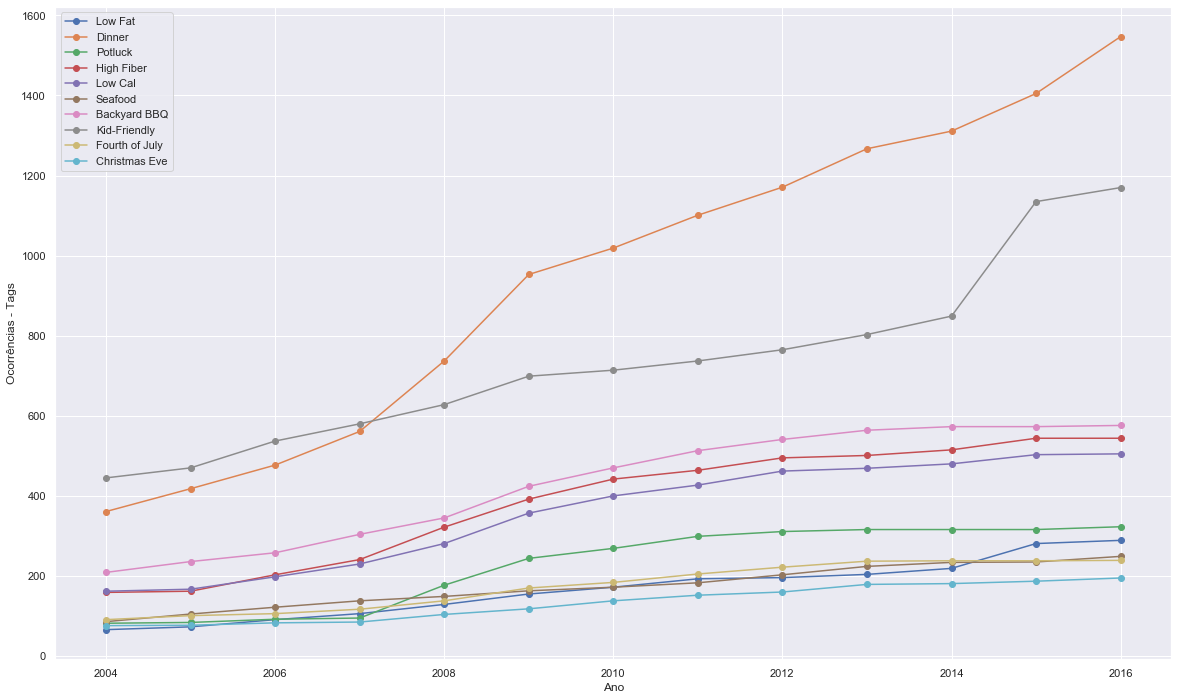

In [51]:
plt.figure(figsize=(20,12))
plt.xlabel('Ano')
plt.ylabel('Ocorrências - Tags')
for col in y:
    soma = f(y[col])
    plt.plot(x,soma,marker='o', label=col);
    plt.legend()

In [52]:
colunas = ['calories', 'sodium', 'fat', 'protein', 'rating']

Vamos seguir analisando as categorias mas virando o foco agora do cresimento delas ao longo do tempo, para os informações nutricionais comuns a cada uma delas, dessa forma, vamos iniciar visualizando as distribuições de valores em cada um dos atributos numéricos, investigando novamente por algum dado "estranho"

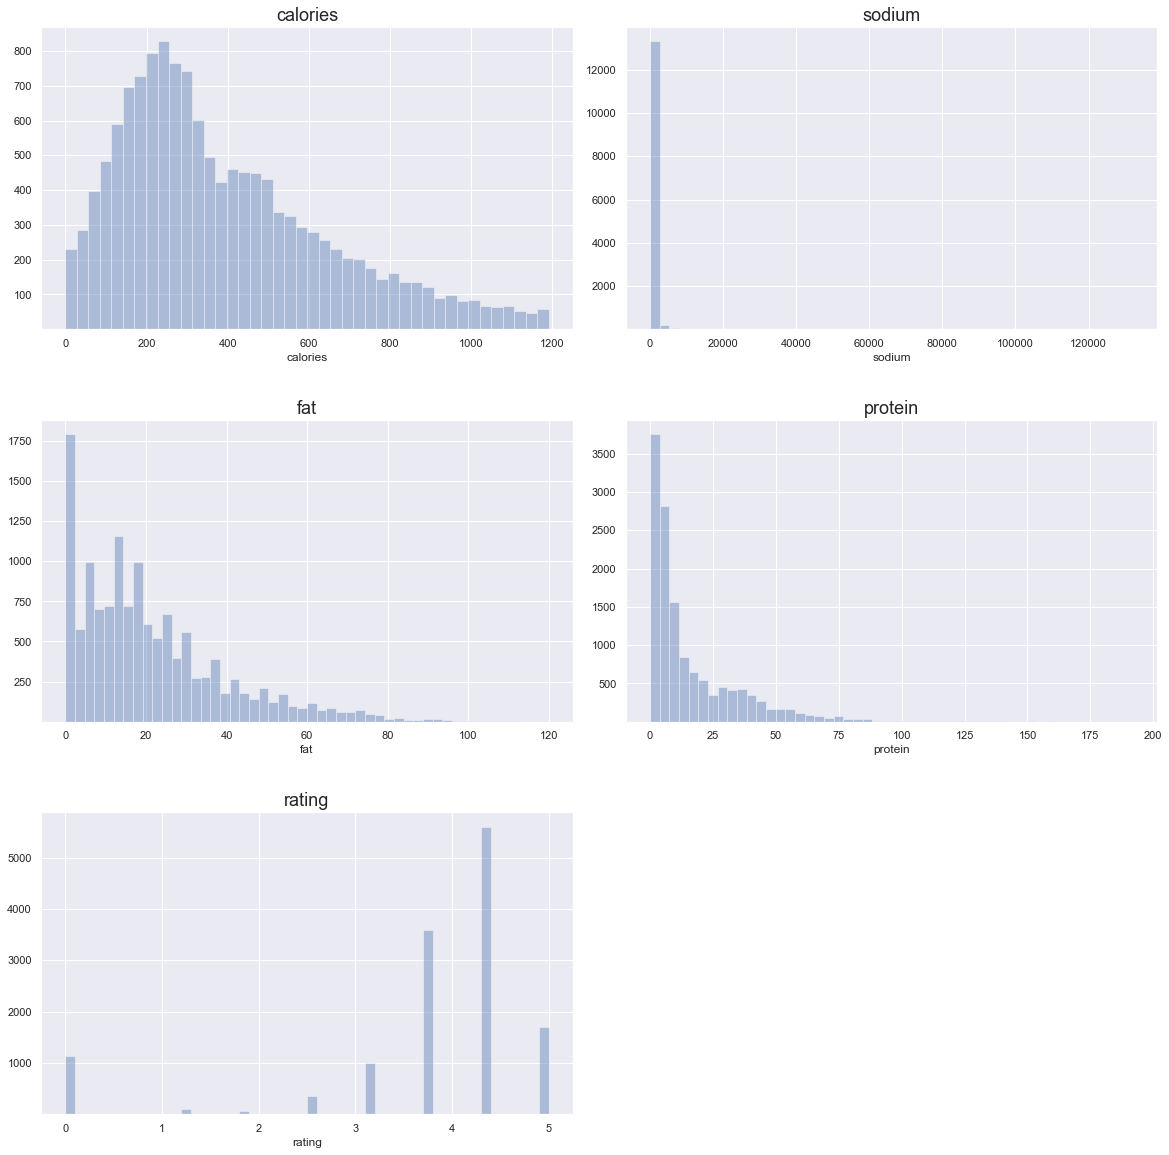

In [53]:
fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.3, wspace=0.1)
i = 1
for col in colunas:
    ax = fig.add_subplot(3, 2, i)
    sns.distplot(receitas[col].dropna(), kde=False, color='b')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5);
    ax.set_title(col, fontsize=18)
    i += 1

plt.show()

Vemos acima que a distribuição dos valores em alguns atributos nos indica para a presença de outliers, que iremos tratar de forma similar ao realizado para a coluna calories.

Boxplot para cada atributo, fica mais claro uma presença muito forte de outliers em sodium

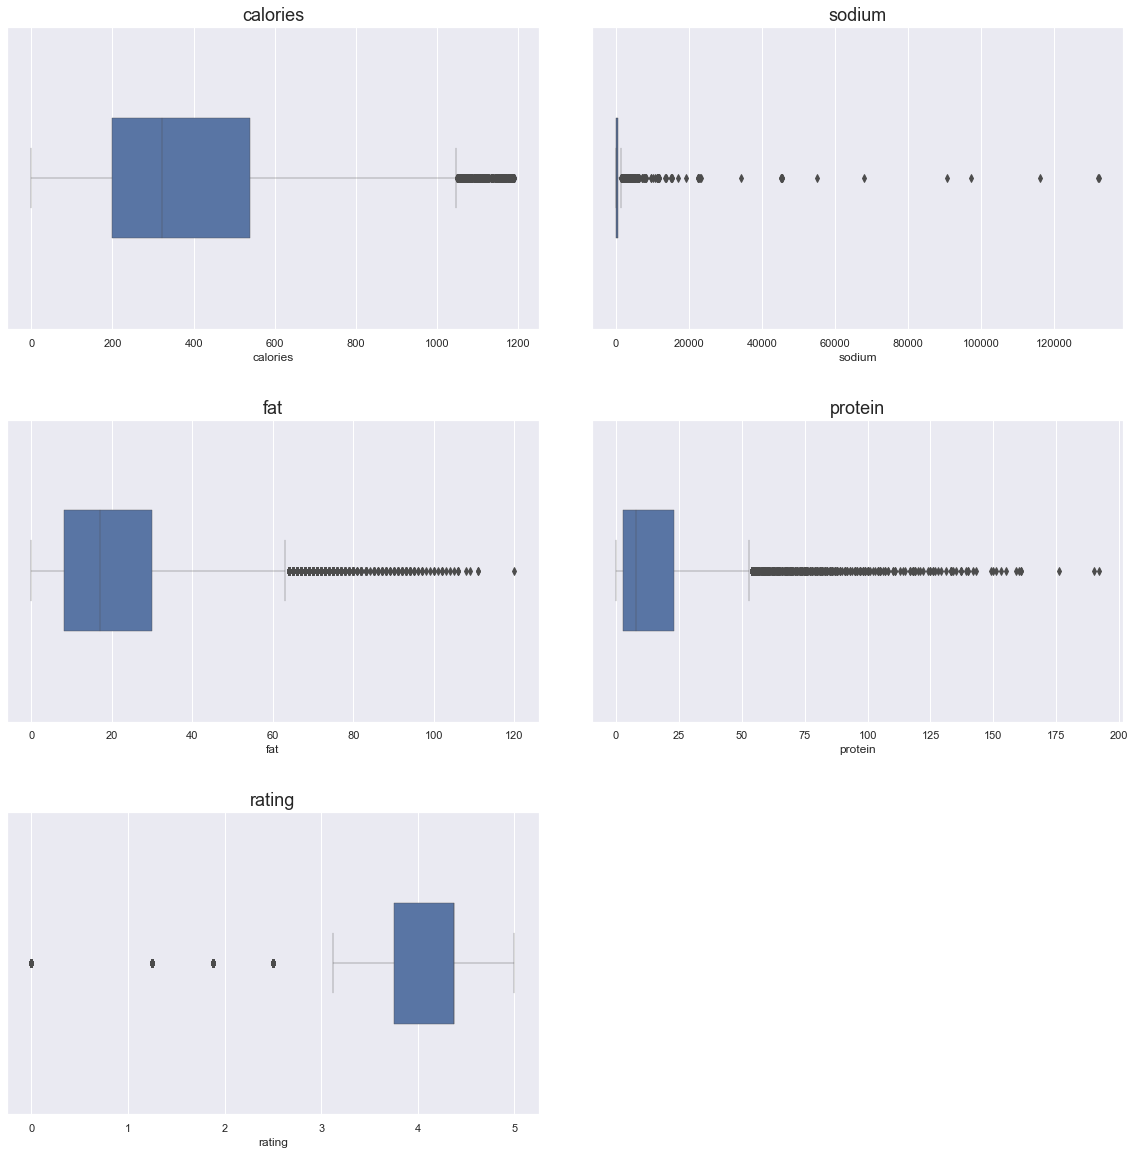

In [54]:
fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.3, wspace=0.1)
i = 1
for col in colunas:
    ax = fig.add_subplot(3, 2, i)
    sns.boxplot(y=col, data=receitas, linewidth=0.4, orient='h');
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5);
    ax.set_title(col, fontsize=18)
    i += 1

plt.show()

In [55]:
colunas[1:len(colunas)-1]

['sodium', 'fat', 'protein']

Fazendo a mesma operação realizada em calories, podemos ver que ainda existem dados vistos como outliers se gerarmos um novo boxplot, poderíamos rodar a operação mais vezes até eliminarmos todos, mas resultaria em uma redução muito impactante no número de instâncias, além de que os valores mais divergentes agora são significativamente menos expressivos que os anteriores.

Drops sodium -> 843


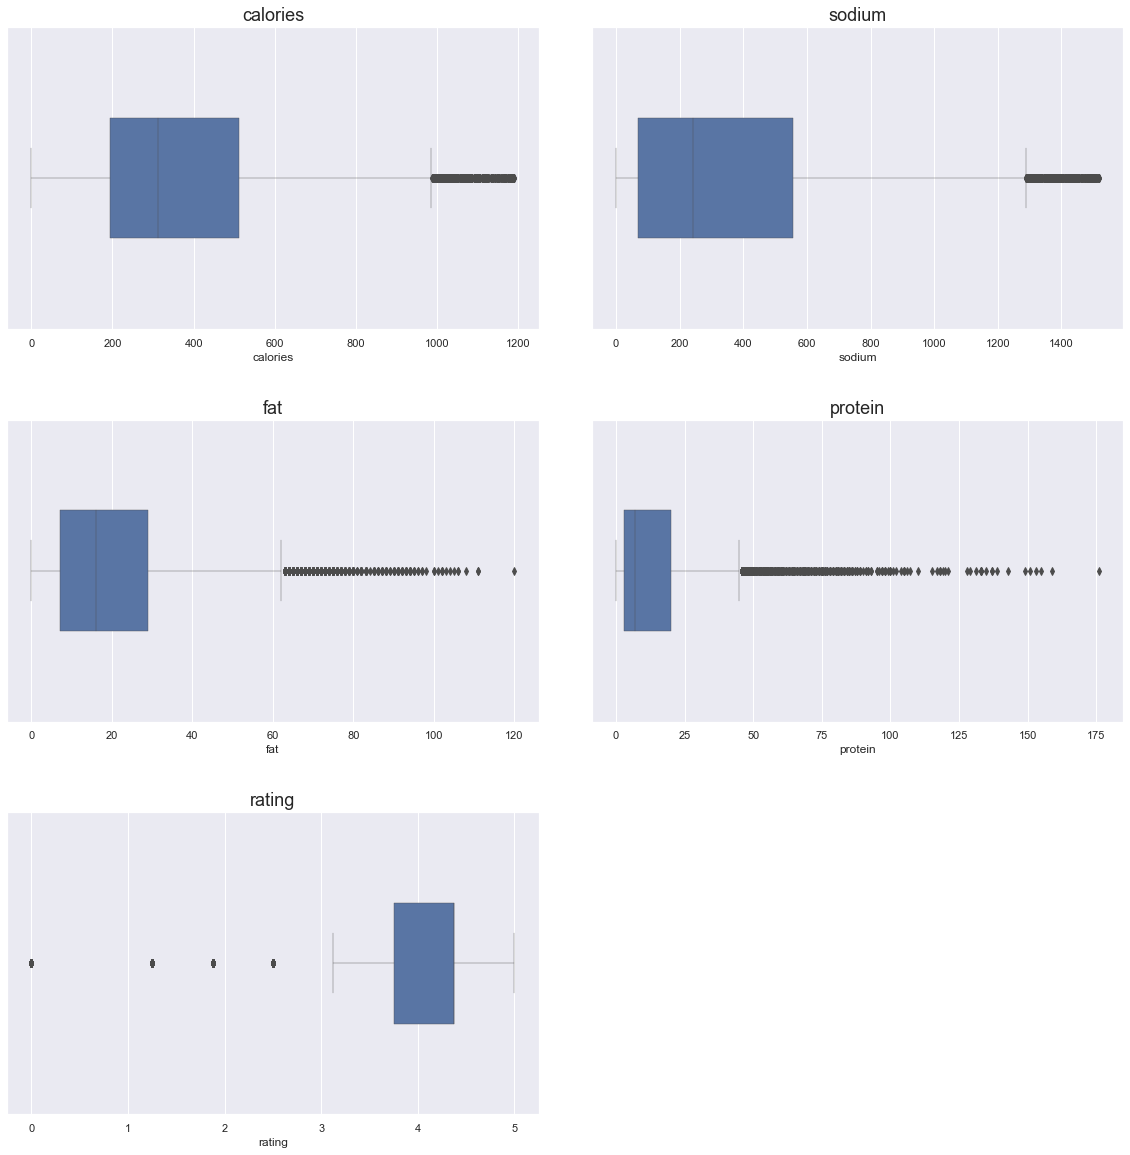

In [56]:
col = 'sodium'
qua = list(receitas[col].quantile([0.25, 0.5, 0.75]))
fiq = qua[2]-qua[0]
low_limit = qua[0] - 1.5*fiq
high_limit = qua[2] + 1.5*fiq
drops = sum(i > high_limit for i in receitas[col])
print(f"Drops {col} -> {drops}")
receitas = receitas[receitas[col] < high_limit]

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.3, wspace=0.1)
i = 1
for col in colunas:
    ax = fig.add_subplot(3, 2, i)
    sns.boxplot(y=col, data=receitas, linewidth=0.4, orient='h');
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5);
    ax.set_title(col, fontsize=18)
    i += 1

plt.show()

Dimensões do daaset após remoções:

In [57]:
receitas.shape

(12737, 12)

Distribuição dos dados após tratamento de outliers:

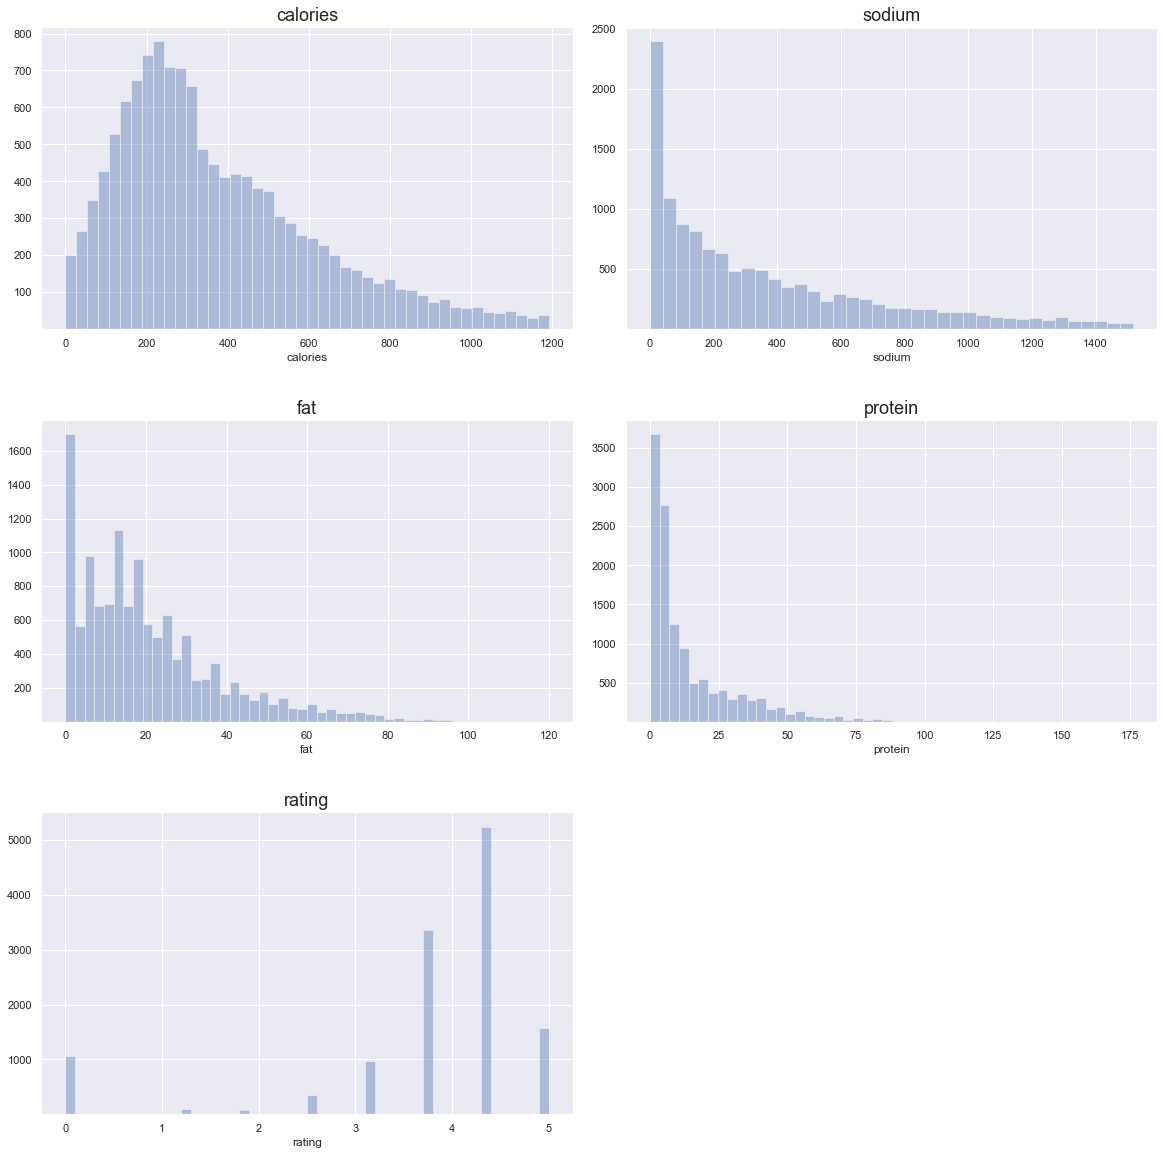

In [58]:
fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.3, wspace=0.1)
i = 1
for col in colunas:
    ax = fig.add_subplot(3, 2, i)
    sns.distplot(receitas[col].dropna(), kde=False, color='b')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5);
    ax.set_title(col, fontsize=18)
    i += 1

plt.show()

Para cada uma das colunas tratadas acima, vamos investigar quais categorias apresentam maiores valores médios

In [59]:
calories = {}
sodium = {}
fat = {}
protein = {}
rating = {}
for c in cat:
    aux = receitas[[c in i for i in receitas['categories'].values]]
    if aux.shape[0] > 0:
        calories[c] = aux['calories'].dropna().sum()/aux.shape[0]
        sodium[c] = aux['sodium'].dropna().sum()/aux.shape[0]
        fat[c] = aux['fat'].dropna().sum()/aux.shape[0]
        protein[c] = aux['protein'].dropna().sum()/aux.shape[0]
        rating[c] = aux['rating'].dropna().sum()/aux.shape[0]
    else:
        calories[c] = 0
        sodium[c] = 0
        fat[c] = 0
        protein[c] = 0
        rating[c] = 0

In [60]:
calories_df = pd.DataFrame.from_dict(calories, orient='index', columns=['Calorias - Média'])
calories_df = calories_df.sort_values(by=['Calorias - Média'], ascending=False)
calories_df.head(10)

,Calorias - Média
Crêpe,1168.000000
Pork Rib,857.142857
Lamb Shank,828.250000
Brisket,814.428571
Lamb Chop,772.545455
Smoker,750.000000
Rack of Lamb,741.300000
Tart,739.500000
Anthony Bourdain,732.500000
Guam,732.000000


In [61]:
sodium_df = pd.DataFrame.from_dict(sodium, orient='index', columns=['Sódio - Média'])
sodium_df = sodium_df.sort_values(by=['Sódio - Média'], ascending=False)
sodium_df.head(10)

,Sódio - Média
Guam,1472.0
Buffalo,1449.0
Costa Mesa,1435.0
Freezer Food,1414.0
Utah,1379.0
Tennessee,1256.0
Burrito,1167.0
Alaska,1143.0
cookbooks,1114.0
Emeril Lagasse,1040.0


In [62]:
fat_df = pd.DataFrame.from_dict(fat, orient='index', columns=['Gordura - Média'])
fat_df = fat_df.sort_values(by=['Gordura - Média'], ascending=False)
fat_df.head(10)

,Gordura - Média
Crêpe,75.000000
Nancy Silverton,66.000000
Lamb Chop,64.909091
Rack of Lamb,61.400000
Pork Rib,59.071429
Brisket,56.571429
Tart,52.666667
Lamb,51.073446
Smoker,50.500000
Beef Rib,48.142857


In [63]:
protein_df = pd.DataFrame.from_dict(protein, orient='index', columns=['Proteína - Média'])
protein_df = protein_df.sort_values(by=['Proteína - Média'], ascending=False)
protein_df.head(10)

,Proteína - Média
Sardine,65.000000
Rabbit,62.666667
Lamb Shank,61.000000
Anthony Bourdain,58.500000
Game,53.000000
Pork Rib,51.642857
Buffalo,50.000000
Venison,47.000000
Smoker,47.000000
Beef Shank,45.285714


In [64]:
rating_df = pd.DataFrame.from_dict(rating, orient='index', columns=['Rating - Média'])
rating_df = rating_df.sort_values(by=['Rating - Média'], ascending=False)
rating_df.head(15)

,Rating - Média
Sourdough,5.000000
Yonkers,5.000000
Louisville,5.000000
Kentucky,5.000000
Chili,5.000000
30 Days of Groceries,5.000000
Emeril Lagasse,5.000000
Burrito,5.000000
Alabama,5.000000
#WasteLess,5.000000


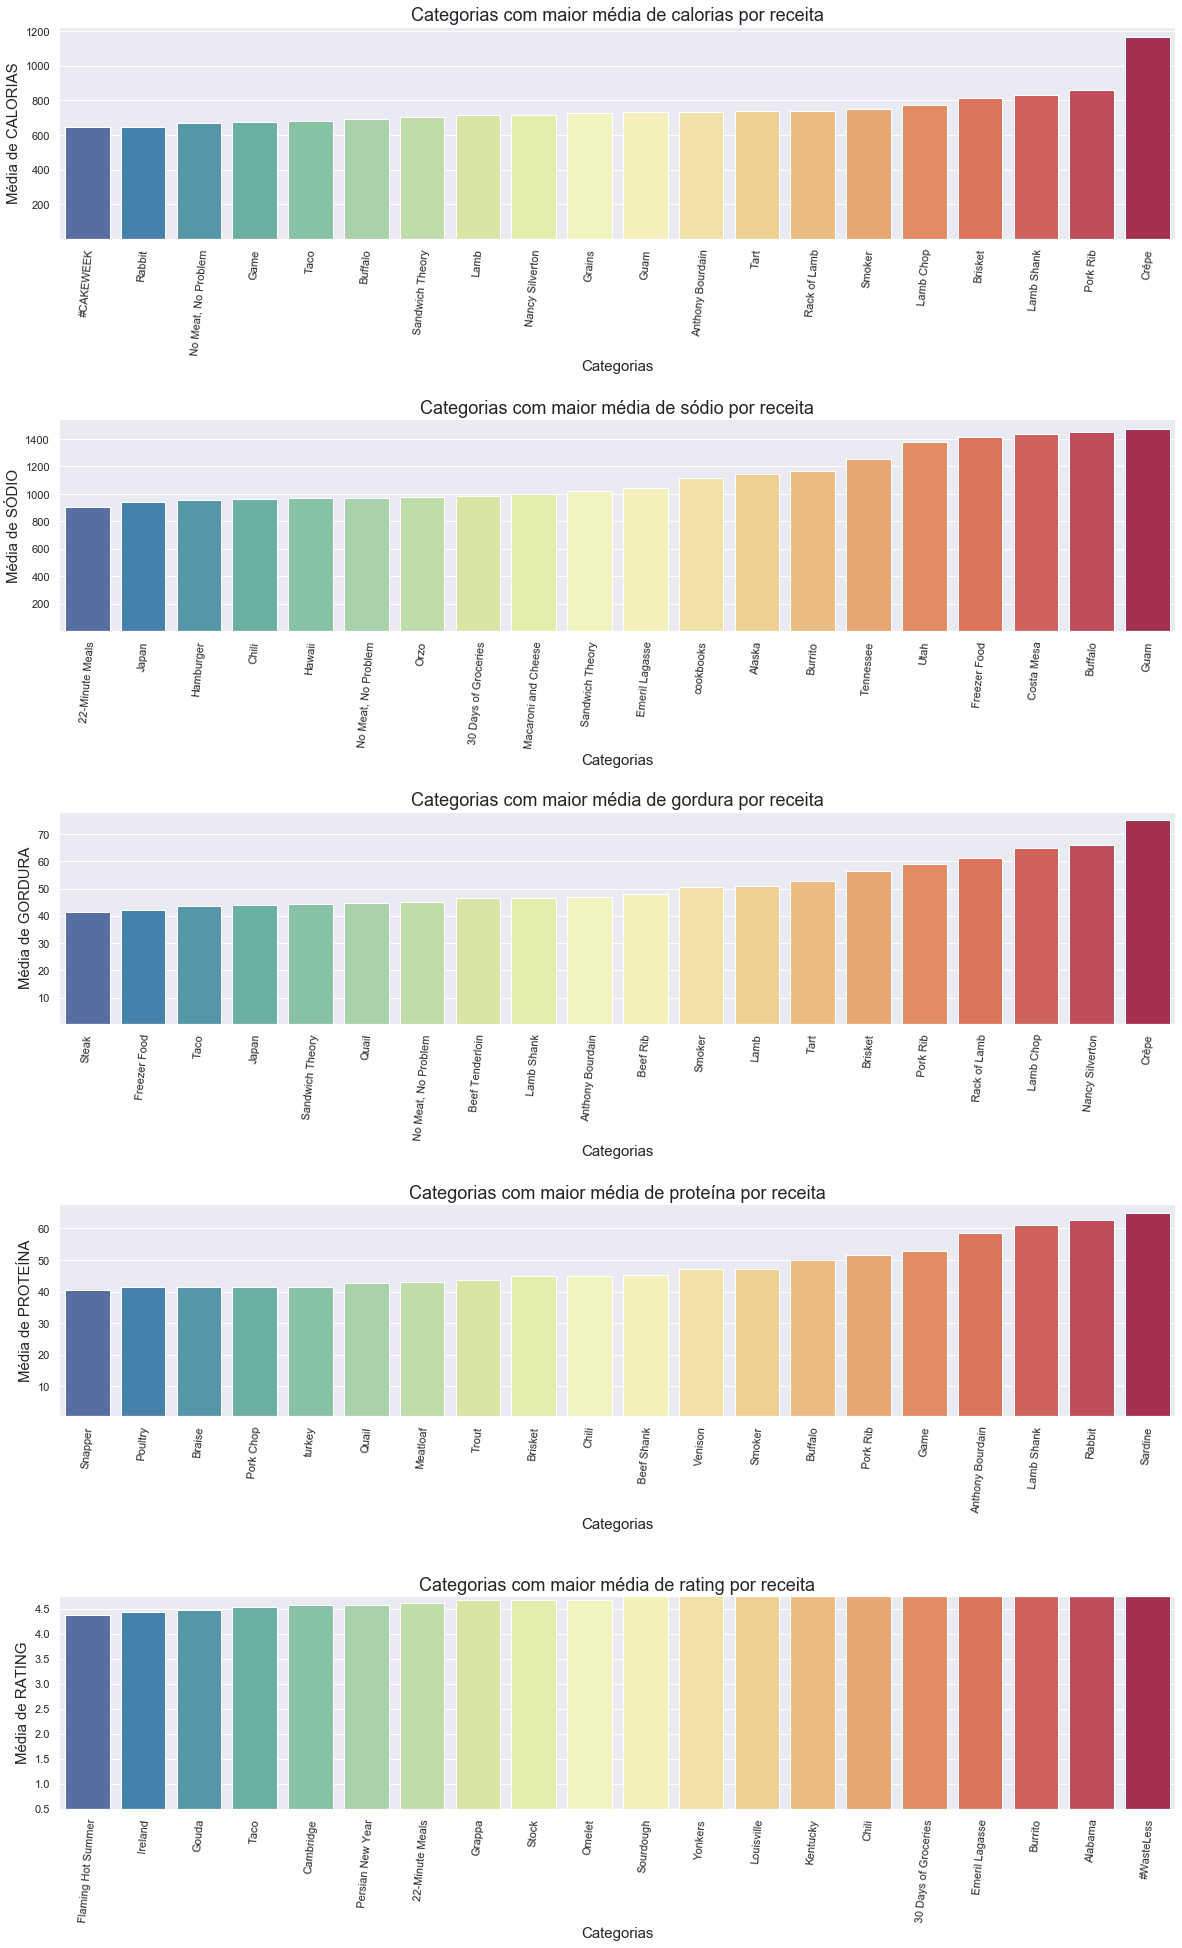

In [65]:
numerics_infos = [calories_df,sodium_df,fat_df,protein_df,rating_df]
names = ['Calorias', 'Sódio', 'Gordura', 'Proteína', 'Rating']
fig = plt.figure(figsize=(20, 40))
fig.subplots_adjust(hspace=0.85, wspace=0.1)
i = 1
for j in range(len(names)):
    ax = fig.add_subplot(6, 1, i)
    aux = [(i[0], i[1]) for i in list(zip(numerics_infos[j].head(20)[f'{names[j]} - Média'], numerics_infos[j].head(20).index))]
    aux = sorted(aux, key=lambda k: k[0])
    #print(aux)
    #plt.figure(figsize=(10, 6))
    #plt.title(f'Categorias com maior média de {names[j].lower()} por receita')
    plt.xlabel('Categorias', fontsize=15)
    plt.ylabel(f'Média de {names[j].upper()}', fontsize=15)
    plt.xticks(rotation=85)
    sns.barplot(x=[i[1] for i in aux], y=[i[0] for i in aux], palette="Spectral_r");
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5);
    ax.set_title(f'Categorias com maior média de {names[j].lower()} por receita', fontsize=18)
    i += 1

plt.show()

Vamos explorar os ingredientes utilisados nas receitas, mas pra isso precisamos de uma forma para extrair as informações, algumas alternativas seriam uso de Expressão Regular, uma abordagem de tentativa e erro, ou uso de processamento de linguagem natural, nos dois primeiros casos seria necessário algum nível de estrutura  padronizada para cada item da lista de receitas, que não é o caso do nosso dataset.

Dessa forma vamos seguir um caminho que apesar de não ser propriamente PLN faz uso de uma tecnica muito comum a problemas dessa natureza, **word embedding**, vamos varrer cada item da lista de ingredientes e verificar a similaridade entre cada substring e a palavra "food", nos fazendo valer do word embedding glove, de gerado pela Universidade de Stamford, e amplamente utilisado em tarefas de NLP, que representa cada palavra de um vocabulário em um espaço, onde cada palavra é um ponto nesse espaço, nos possibilitando comparar dois pontos, como faremos abaixo.

In [66]:
filename = 'glove-twitter-25'
try:
    model = KeyedVectors.load_word2vec_format(filename, binary=False)
except:
    model = gensim.downloader.load(filename)
    model.save(filename)

In [67]:
def get_best_similarity(l, target):
    r = []
    
    kitchen_units = ['teaspoons', 'teaspoon', 'tablespoons', 'tablespoon', 
                     'cups', 'cup', 'pinch of', 'pinch', 'slices of', 'slices',
                     'slice', 'sliced', 'ounces', 'ounce', 'pounds', 'pound', 'packages',
                     'package', 'whole', 'jars', 'jar', 'inches', 'inch', ' lb',
                     'all purpose', 'all-purpose', 'large', 'tsp', 'tbsp', ' ml', 
                     'quart', 'ground', ' in ', ' on ', ' or ', ' and ', ' half ', 'thinly',
                     'chopped', ' to ', ' small ', ' big ', ' medium ', ' cut ', ' of ', ' minced ',
                     ' ripe ', ' into ', ' d ', 'pieces', 'fresh', 'taste']        
    
    for i in l:
        sentence = i.replace(',', '').replace('.', '')
        lim1 = sentence.find('(')
        lim2 = sentence.find(')')
        if lim1 > -1 and lim2 > -1:
            sentence = sentence[:lim1] + sentence[lim2+1:]
            
        for w in kitchen_units:
            sentence = sentence.replace(w, ' ')
        sentence = sentence.split(" ")
        best_fit = 0
        indices = (-1,-1)
        for j in range(len(sentence)):
            for k in range(1, len(sentence)+1):
                vec = sentence[j:k]
                if vec == [] or vec == target:
                    continue
                try:
                    fit = model.n_similarity(vec, target)
                    #print(f"{vec} -> {fit}")
                    if (fit > best_fit) or (fit > best_fit*0.95 and len(vec) > len(sentence[indices[0]:indices[1]])):
                        best_fit = fit
                        indices = (j, k)
                except:
                    continue
        if indices != (-1,-1):
            r.append(" ".join(sentence[indices[0]:indices[1]]))
        else:
            r.append(i)
    return r

In [68]:
receitas['ingredients'] = receitas['ingredients'].apply(lambda x: x.split("#!#"))

Execução de ilustração:

In [69]:
teste = list(receitas['ingredients'])[0]
teste

['4 cups low-sodium vegetable or chicken stock',
 '1 cup dried brown lentils',
 '1/2 cup dried French green lentils',
 '2 stalks celery, chopped',
 '1 large carrot, peeled and chopped',
 '1 sprig fresh thyme',
 '1 teaspoon kosher salt',
 '1 medium tomato, cored, seeded, and diced',
 '1 small Fuji apple, cored and diced',
 '1 tablespoon freshly squeezed lemon juice',
 '2 teaspoons extra-virgin olive oil',
 'Freshly ground black pepper to taste',
 '3 sheets whole-wheat lavash, cut in half crosswise, or 6 (12-inch) flour tortillas',
 '3/4 pound turkey breast, thinly sliced',
 '1/2 head Bibb lettuce']

In [70]:
get_best_similarity(teste, ['food'])

['chicken stock',
 'dried brown',
 'green',
 'celery',
 'carrot',
 'thyme',
 'salt',
 'tomato',
 'apple',
 'juice',
 'olive oil',
 'black pepper',
 'flour tortillas',
 'turkey breast',
 'head']

Aplicando operação a cada elemento da coluna:

In [71]:
%%time
receitas['extracted_ingredients'] = receitas['ingredients'].apply(lambda x : get_best_similarity(x, ['food']))

Wall time: 1min 11s


In [72]:
ingr = {}
receitas_ingr = list(receitas['extracted_ingredients'])

for ings in receitas_ingr:
    for i in ings:
        if i not in ingr:
            ingr[i] = 1
        else:
            ingr[i] += 1

Ingredientes mais utilisados em receitas - geral e com valores:

In [73]:
ingrs_occ = pd.DataFrame.from_dict(ingr, orient='index', columns=['Ocorrências'])
ingrs_occ = ingrs_occ.sort_values(by=['Ocorrências'], ascending=False)
ingrs_occ.head(30)

,Ocorrências
sugar,5690
salt,5245
olive oil,3814
juice,3811
butter,3235
garlic,3175
water,2316
flour,2226
black pepper,1845
cream,1810


Gráfico de número de ocorrências de cada uma dos top30 ingredientes mais populares:

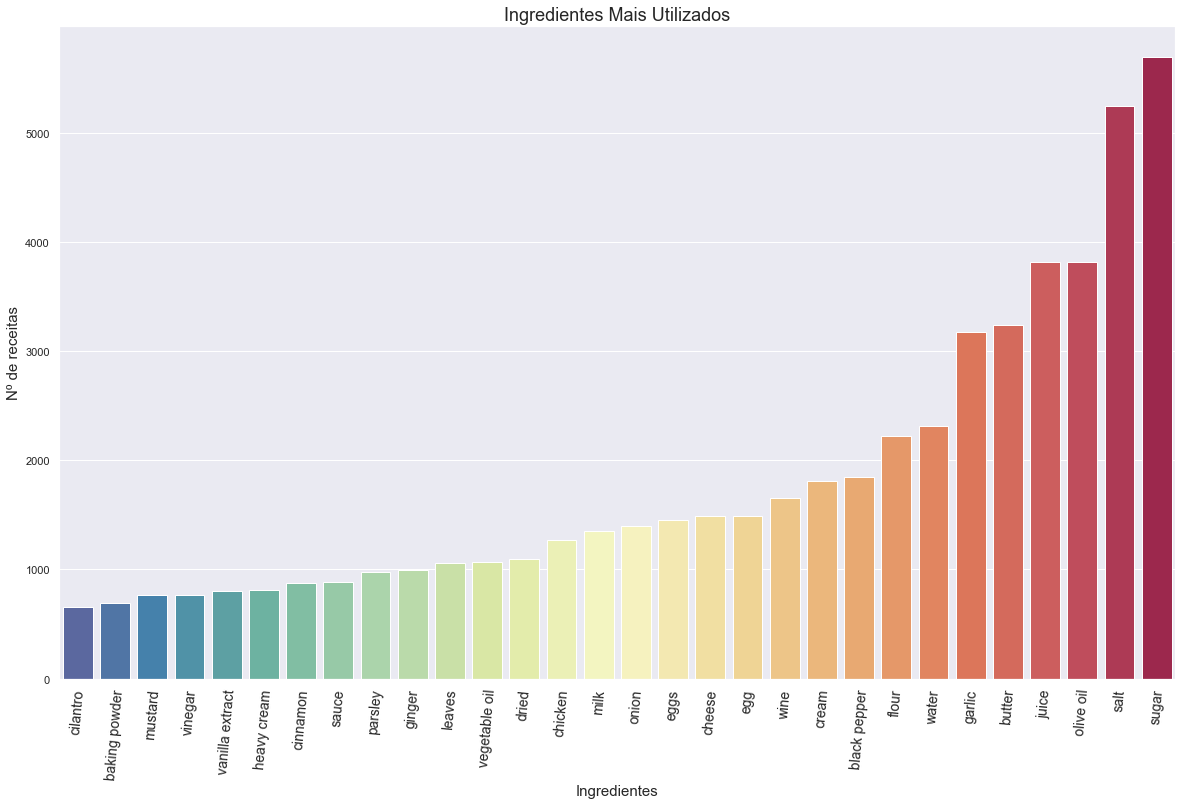

In [74]:
aux = [(i[0], i[1]) for i in list(zip(ingrs_occ.head(30)['Ocorrências'], ingrs_occ.head(30).index))]
aux = sorted(aux, key=lambda k: k[0])
#print(aux)
plt.figure(figsize=(20, 12))
plt.title('Ingredientes Mais Utilizados', fontsize=18)
plt.ylabel('Nº de receitas', fontsize=15)
plt.xlabel('Ingredientes', fontsize=15)
plt.xticks(rotation=85, fontsize=14)
#sns.barplot(x=countries, y=occ, order=sorted(occ, reverse=True));
#sns.barplot(x='year', y='calories', data=receitas.dropna(subset=['calories']), palette="Spectral");
sns.barplot(x=[i[1] for i in aux], y=[i[0] for i in aux], palette="Spectral_r");

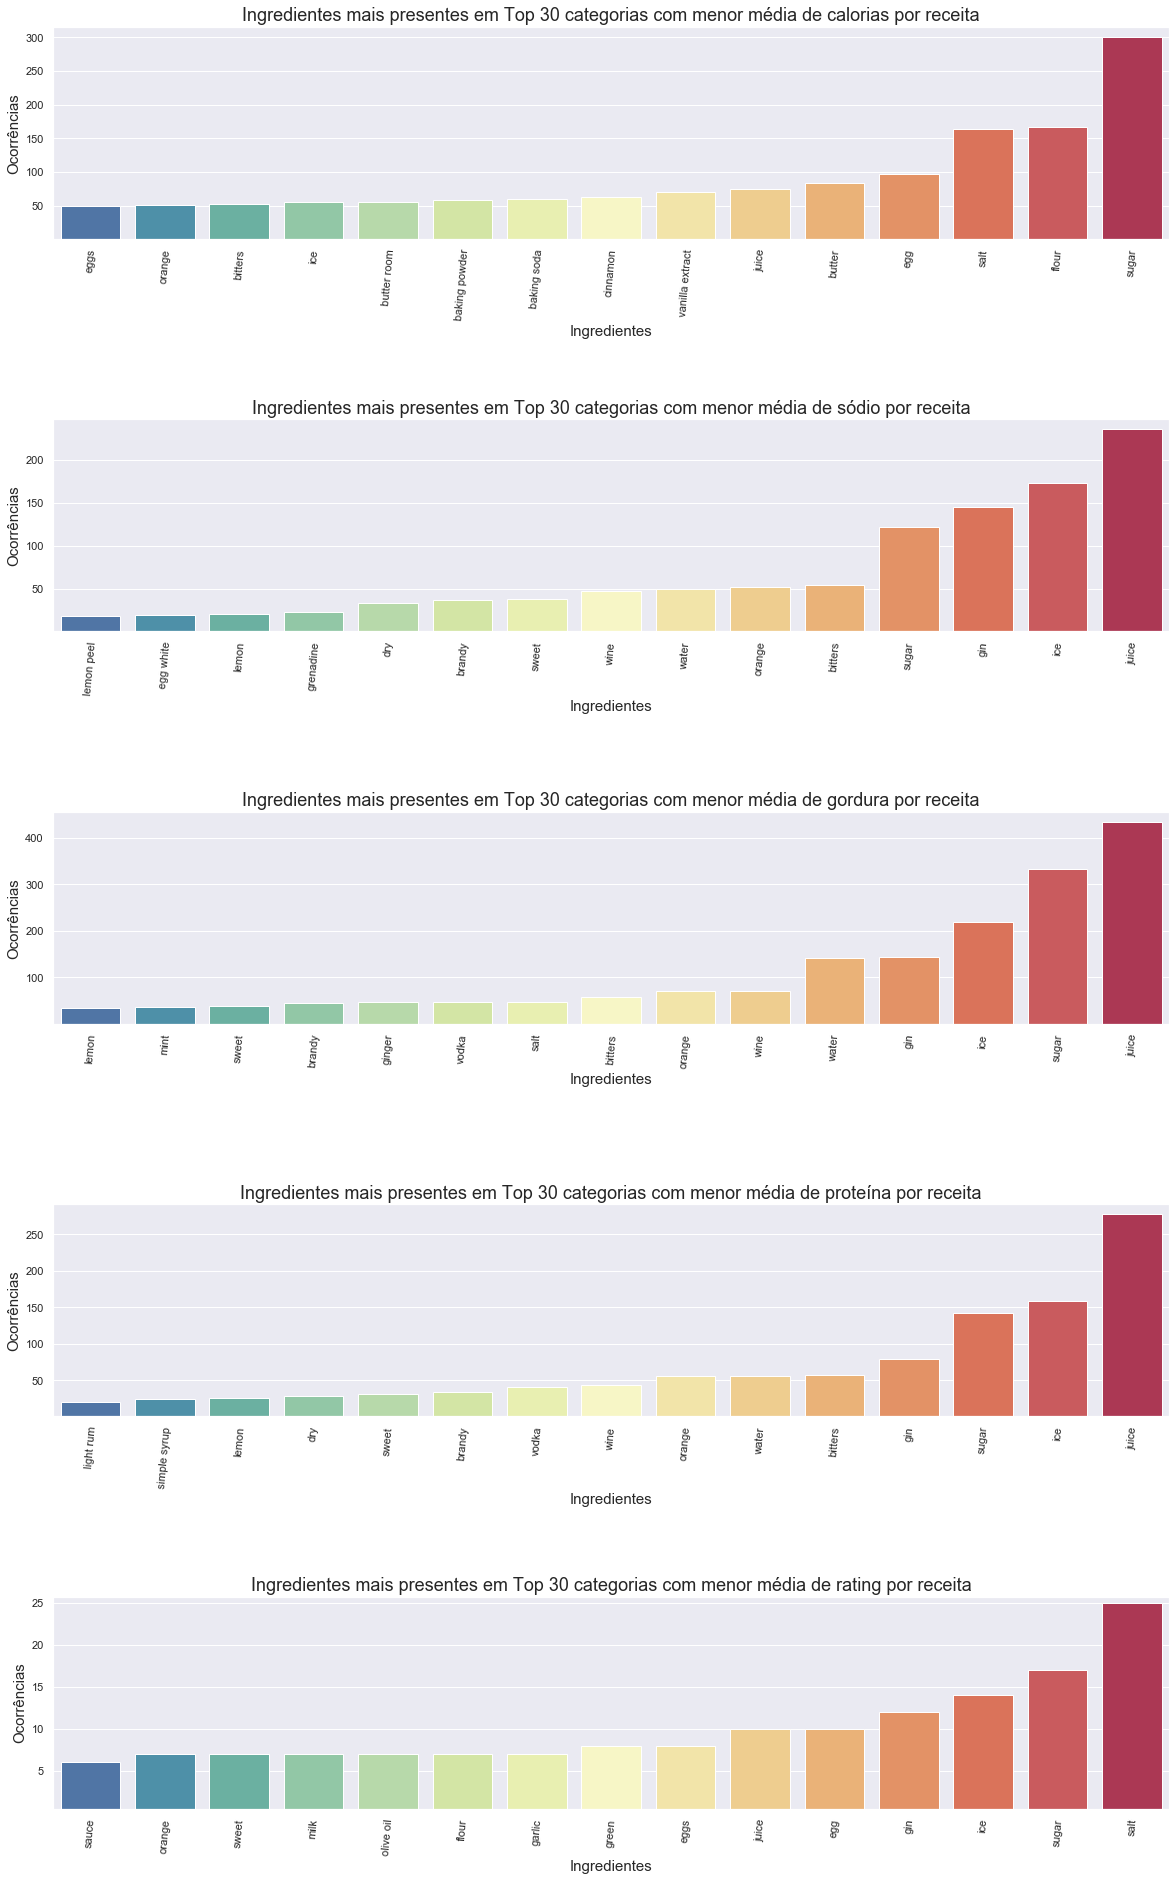

In [75]:
numerics_infos = [calories_df,sodium_df,fat_df,protein_df,rating_df]
names = ['Calorias', 'Sódio', 'Gordura', 'Proteína', 'Rating']
fig = plt.figure(figsize=(20, 40))
fig.subplots_adjust(hspace=0.85, wspace=0.1)
grid = 1

for i in range(len(names)):
    df = numerics_infos[i].tail(30)
    cats = list(df.index)
    l = list(receitas['categories'])
    tmp = []
    for k in range(len(l)):
        check = False
        for c in cats:
            if c in l[k]:
                check = True
                break
        tmp.append(check)
    aux = receitas[tmp]

    ingr = {}
    receitas_ingr = list(aux['extracted_ingredients'])

    for ings in receitas_ingr:
        for j in ings:
            if j not in ingr:
                ingr[j] = 1
            else:
                ingr[j] += 1
    
    ingrs_occ = pd.DataFrame.from_dict(ingr, orient='index', columns=['Ocorrências'])
    ingrs_occ = ingrs_occ.sort_values(by=['Ocorrências'], ascending=False)
    #print(ingrs_occ)
    aux = [(i[0], i[1]) for i in list(zip(ingrs_occ.head(15)['Ocorrências'], ingrs_occ.head(15).index))]
    aux = sorted(aux, key=lambda k: k[0])
    '''plt.figure(figsize=(20, 12))
    plt.title('Ingredientes Mais Utilizados', fontsize=18)
    plt.ylabel('Nº de receitas', fontsize=15)
    plt.xlabel('Ingredientes', fontsize=15)
    plt.xticks(rotation=85, fontsize=14)
    sns.barplot(x=[i[1] for i in aux], y=[i[0] for i in aux], palette="Spectral_r");'''
    
    ax = fig.add_subplot(6, 1, grid)
    plt.xlabel('Ingredientes', fontsize=15)
    plt.ylabel(f'Ocorrências', fontsize=15)
    plt.xticks(rotation=85)
    sns.barplot(x=[i[1] for i in aux], y=[i[0] for i in aux], palette="Spectral_r");
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5);
    #print(i)
    ax.set_title(f'Ingredientes mais presentes em Top 30 categorias com menor média de {names[i].lower()} por receita', fontsize=18)
    grid += 1

plt.show()

Acima principais ingredientes usados em categorias com menores valores médios de calories, sodium, fat, protein e rating, abaixo para as mesmas colunas, mas categorias com maiores médias.

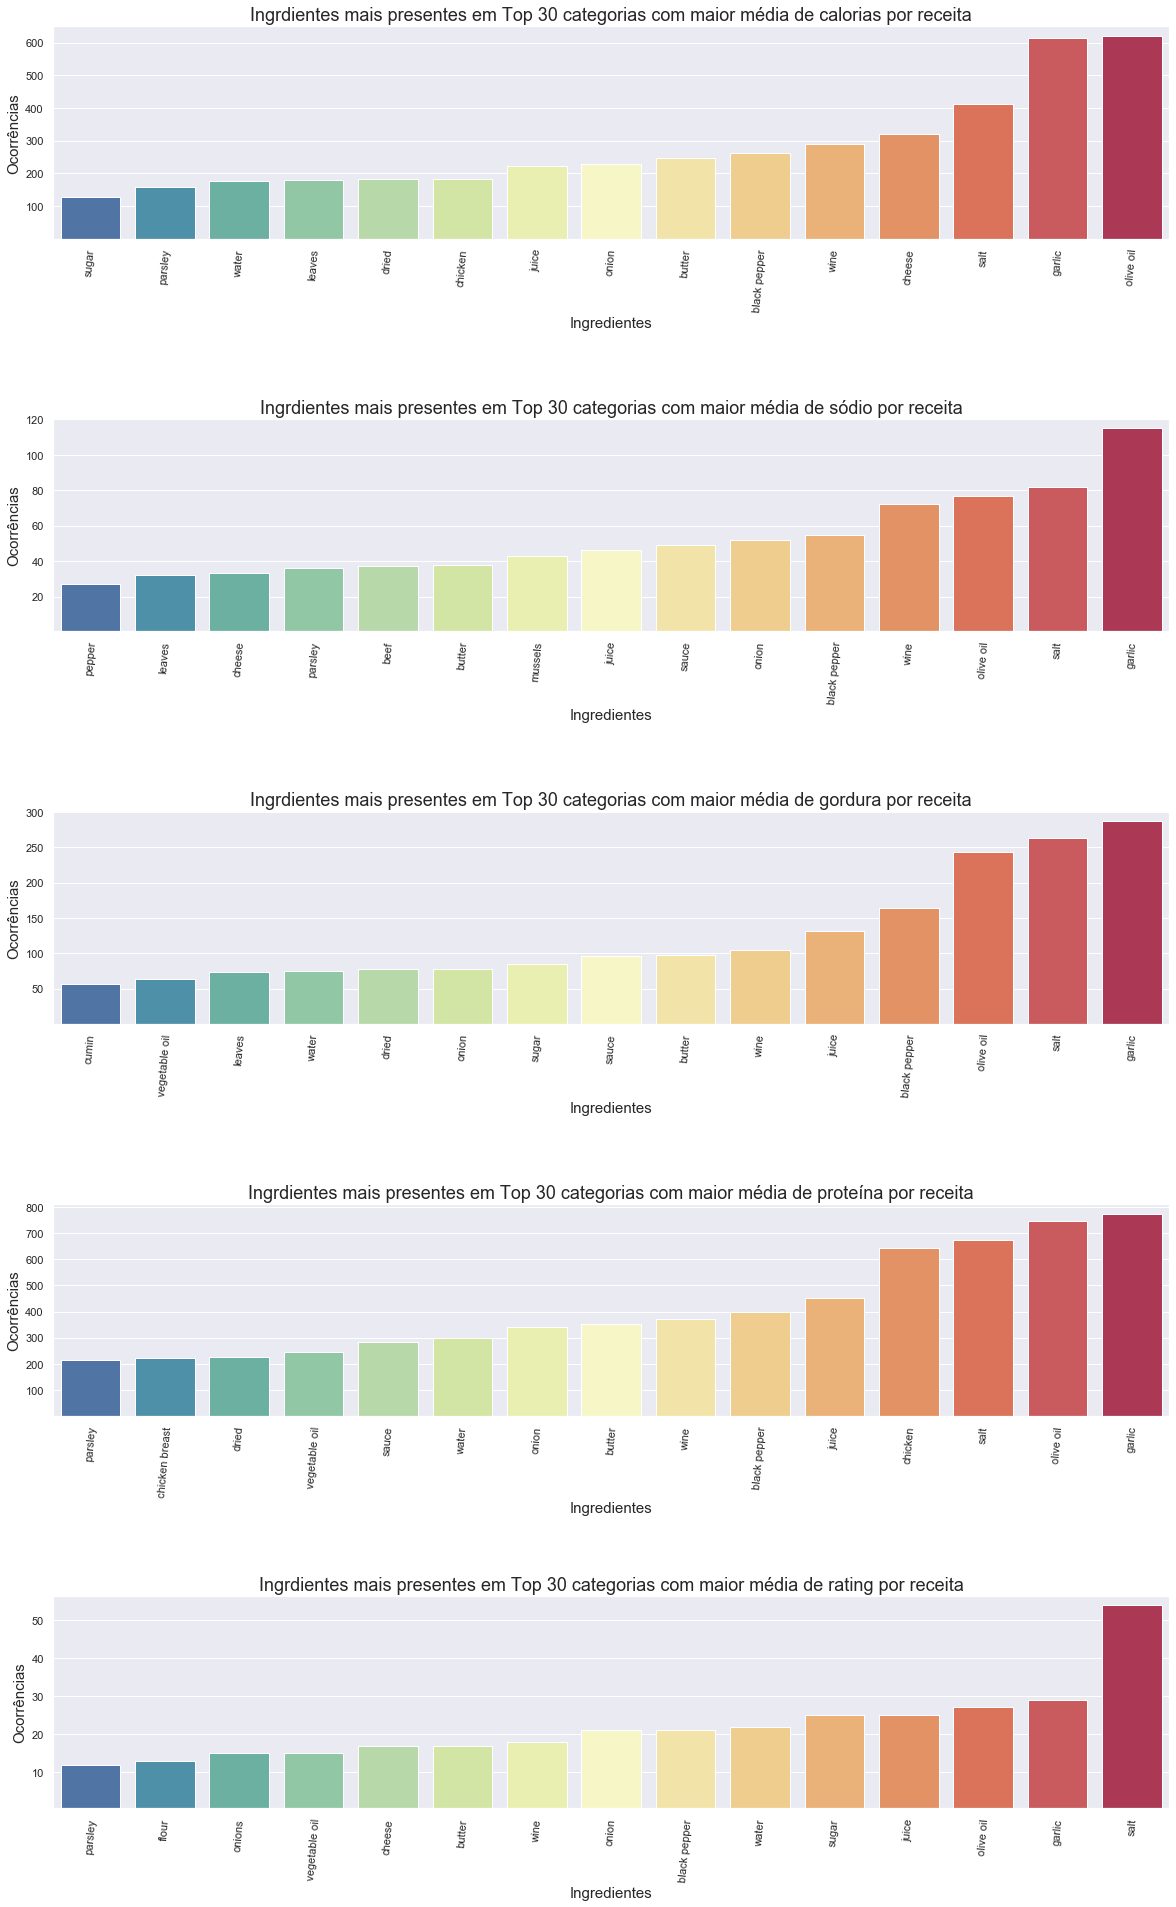

In [76]:
numerics_infos = [calories_df,sodium_df,fat_df,protein_df,rating_df]
names = ['Calorias', 'Sódio', 'Gordura', 'Proteína', 'Rating']
fig = plt.figure(figsize=(20, 40))
fig.subplots_adjust(hspace=0.85, wspace=0.1)
grid = 1

for i in range(len(names)):
    df = numerics_infos[i].head(30)
    cats = list(df.index)
    l = list(receitas['categories'])
    tmp = []
    for k in range(len(l)):
        check = False
        for c in cats:
            if c in l[k]:
                check = True
                break
        tmp.append(check)
    aux = receitas[tmp]

    ingr = {}
    receitas_ingr = list(aux['extracted_ingredients'])

    for ings in receitas_ingr:
        for j in ings:
            if j not in ingr:
                ingr[j] = 1
            else:
                ingr[j] += 1
    
    ingrs_occ = pd.DataFrame.from_dict(ingr, orient='index', columns=['Ocorrências'])
    ingrs_occ = ingrs_occ.sort_values(by=['Ocorrências'], ascending=False)
    #print(ingrs_occ)
    aux = [(i[0], i[1]) for i in list(zip(ingrs_occ.head(15)['Ocorrências'], ingrs_occ.head(15).index))]
    aux = sorted(aux, key=lambda k: k[0])
    '''plt.figure(figsize=(20, 12))
    plt.title('Ingredientes Mais Utilizados', fontsize=18)
    plt.ylabel('Nº de receitas', fontsize=15)
    plt.xlabel('Ingredientes', fontsize=15)
    plt.xticks(rotation=85, fontsize=14)
    sns.barplot(x=[i[1] for i in aux], y=[i[0] for i in aux], palette="Spectral_r");'''
    
    ax = fig.add_subplot(6, 1, grid)
    plt.xlabel('Ingredientes', fontsize=15)
    plt.ylabel(f'Ocorrências', fontsize=15)
    plt.xticks(rotation=85)
    sns.barplot(x=[i[1] for i in aux], y=[i[0] for i in aux], palette="Spectral_r");
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5);
    #print(i)
    ax.set_title(f'Ingrdientes mais presentes em Top 30 categorias com maior média de {names[i].lower()} por receita', fontsize=18)
    grid += 1

plt.show()

Finalizando nossa exploração vamos checar possíveis correlações entre os atributos do dataset, adicionando contadores de número de etapas, ingredientes ecategorias.

In [77]:
receitas['n_ingredients'] = receitas['ingredients'].apply(len)

In [78]:
receitas['directions'] = receitas['directions'].apply(lambda x: x.split("#!#"))
receitas['n_steps'] = receitas['directions'].apply(len)

In [79]:
receitas['n_tags'] = receitas['categories'].apply(len)

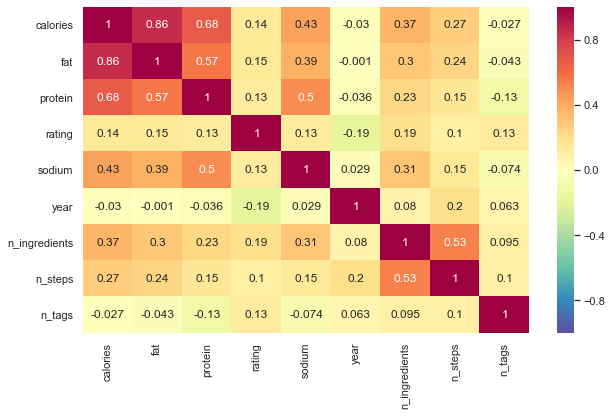

In [80]:
plt.figure(figsize=(10, 6))
corrMatrix = receitas.corr()
ax = sns.heatmap(corrMatrix, annot=True, cmap='Spectral_r', vmin=-1,vmax=1)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);